In [1]:
## imports 
# astro
from    astropy.wcs             import WCS
from    astropy.io              import fits
import  astropy.units           as u
from    astropy.nddata          import Cutout2D
from    astropy.coordinates     import SkyCoord
from    astropy.visualization   import (MinMaxInterval, PercentileInterval, ZScaleInterval, SqrtStretch, AsinhStretch, LogStretch, ImageNormalize)
# data 
import  numpy   as np
import  pandas  as pd
# plots
import  matplotlib.pyplot as plt

## file paths 
path_catalogs = 'D:\\AstroCatalogs\\AGNerds'
path_cutouts = 'C:\\Users\\polar\\OneDrive - The University of Kansas\\AGNerds\\AGNerds\\JWST_AGN_proj2\\Cutouts_duplicates'

# Read Files

In [2]:
# read file to get agn info
df_galaxyCoordinants = pd.read_csv('tphotCoord_egs_duplicate_galaxies.csv', sep=',')
# display(df_agn)

In [3]:
# build dictionary of data, header, and wcs for a given fits file
def GetData(fitsFile):
    f = fits.open(fitsFile)
    dataDict = {
        'data'      : fits.getdata(fitsFile),
        'header'    : fits.getheader(fitsFile),
        'wcs'       : WCS(f[1].header)
    }
    f.close()
    return(dataDict)

In [4]:
# read CEERS MIRI (cm) image data
miri = {
    1 : {
        'f1000w' : GetData(path_catalogs+'\\ceers_miri1_f1000w_i2d.fits'),
        'f1280w' : GetData(path_catalogs+'\\ceers_miri1_f1280w_i2d.fits'),
        'f770w'  : GetData(path_catalogs+'\\ceers_miri1_f770w_i2d.fits')
    },
    2 : {
        'f1000w' : GetData(path_catalogs+'\\ceers_miri2_f1000w_i2d.fits'),
        'f1280w' : GetData(path_catalogs+'\\ceers_miri2_f1280w_i2d.fits'),
        'f770w'  : GetData(path_catalogs+'\\ceers_miri2_f770w_i2d.fits')
    },
    3 :{
        'f770w'  : GetData(path_catalogs+'\\ceers_miri3_f770w_i2d.fits')
    },
    6 : {
        'f770w'  : GetData(path_catalogs+'\\ceers_miri6_f770w_i2d.fits')
    },
}

Set DATE-AVG to '2022-06-21T19:01:47.926' from MJD-AVG.
Set DATE-END to '2022-06-21T19:17:17.099' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.743944 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725242515.981 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-21T19:37:34.014' from MJD-AVG.
Set DATE-END to '2022-06-21T19:52:51.177' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.748835 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725268421.305 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-21T18:25:23.072' from MJD-AVG.
Set DATE-END to '2022-06-21T18:40:42.862' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.739047 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725216509.255 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-21T23:48:57.498' from MJD-AVG.
Set DATE-END to '2022-06-22T00:04:15.579' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.782898 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725446993.656 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE

# Functions for Image Cutouts

In [21]:
def GetCutout(
    coord,  # center sky coordinate
    wcs,    # World Coordinate System
    data,   # image data
    dl=50   # cutout size 
):
    # get position on sky 
    x, y = wcs.world_to_pixel(coord)
    # make cutout 
    cutout = Cutout2D(data, position=(x,y), size=(dl,dl), wcs=wcs, mode='partial')
    return(cutout)

In [26]:
def PlotCutout(
    ax,
    cutout,
    center, # dl/2
    title,  # title 
    marks=[],   # add markers to these coordinantes
    useNorm=None,
    showGrid=False
) : 
    if(showGrid):
        # grid lines
        ax.grid(True, color='r', linestyle='--', linewidth=0.5)
    else:
        # hide ticks
        ax.set_xticks([])
        ax.set_yticks([])
    # hide axis lables
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')

    if(marks):
        for coord in marks : 
            ax.plot_coord(coord, "+", color="red")
    else:
        # circle center coord 
        circle = plt.Circle((center,center), 10, fc=(0,0,0,0), ec="red")
        ax.add_patch(circle)

    # set title
    ax.set_title(title,fontsize=14)
    
    # plot image
    if(useNorm == None) : 
        ax.imshow(cutout.data, origin='lower', cmap='gray')
    else:
        norm1 = ImageNormalize(cutout.data, interval=PercentileInterval(useNorm), stretch=AsinhStretch())
        ax.imshow(cutout.data, origin='lower', cmap='gray', norm=norm1)

In [23]:
def MakePlotOfSrc_OneBand(
    coord,  # SkyCoord of RA and Dec
    wcs,    # World Coordinate System
    data,   # image data
    band,   # title of subplot 
    title,  # plot title
    marks=[],   # add markers to these coordinantes.
    useNorm=None,   # normalization percent interval
    showGrid=False,
    dl=50,  # cutout size  
    fileName=''     # name and path of file to save to
):
    # image cutout  
    cutout = GetCutout(
        coord=coord,  # center sky coordinate
        wcs=wcs,    # World Coordinate System
        data=data,   # image data
        dl=dl   # cutout size 
    )
    # make figure 
    fig = plt.figure(figsize=(4,4.25), facecolor='white')
    if(showGrid):
        ax = fig.add_subplot(111, projection=cutout.wcs)
        fig.supxlabel('RA')
        fig.supylabel('Dec')
    else:
        ax = fig.add_subplot(111, projection=cutout.wcs)
        
    # plot image cutout on axis 
    PlotCutout(
        ax=ax,
        cutout=cutout,
        center=dl/2.0, 
        title=band,
        marks=marks,
        useNorm=useNorm,
        showGrid=showGrid
    )
   
    # labels
    fig.suptitle(title, fontsize=16)

    # save 
    if(fileName):
        plt.savefig(    fileName,
                        bbox_inches ="tight",
                        pad_inches=0.05,
                        facecolor='w',
                        edgecolor='w'
        )

In [24]:
def MakePlotOfSrc_ThreeBands(
    ra,     # right ascension [deg]
    dec,    # declination [deg]
    wcs1,  wcs2,  wcs3,    # World Coordinate System
    data1, data2, data3,   # image data
    band1, band2, band3,   # title of subplot 
    title,  # plot title 
    marks=[],   # add markers to these coordinantes.
    useNorm=None,   # normalization percent interval
    showGrid=False,
    dl=50,  # cutout size  
    fileName=''     # name and path of file to save to
):
    # image cutout  
    cutout1 = GetCutout(ra,dec,wcs1,data1)
    cutout2 = GetCutout(ra,dec,wcs2,data2)
    cutout3 = GetCutout(ra,dec,wcs3,data3)

    # make figure 
    fig = plt.figure(figsize=(12,4), facecolor='white')
    if(showGrid):
        ax1 = fig.add_subplot(131, projection=cutout1.wcs)
        ax2 = fig.add_subplot(132, projection=cutout2.wcs)
        ax3 = fig.add_subplot(133, projection=cutout3.wcs)
        fig.supxlabel('RA')
        fig.supylabel('Dec')
    else:
        ax1 = fig.add_subplot(131)
        ax2 = fig.add_subplot(132)
        ax3 = fig.add_subplot(133)

    # plot image cutout on axis 
    PlotCutout(ax1, cutout1, dl/2, band1, marks, useNorm, showGrid)
    PlotCutout(ax2, cutout2, dl/2, band2, marks, useNorm, showGrid)
    PlotCutout(ax3, cutout3, dl/2, band3, marks, useNorm, showGrid)
    
    # labels
    fig.suptitle(title, fontsize=16)

    # save 
    if(fileName):
        plt.savefig(    fileName,
                        bbox_inches ="tight",
                        pad_inches=0.05,
                        facecolor='w',
                        edgecolor='w'
        )

# Plot Single Object

,Field,RA_tphot,Dec_tphot,RA_egs,Dec_egs
10,miri2,215.074137,52.973012,215.074351,52.973198


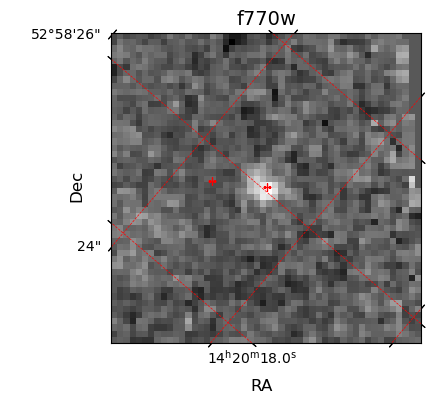

In [27]:
# example source
i = 10
display(df_galaxyCoordinants.iloc[[i]])

field_i = int(df_galaxyCoordinants.at[i,'Field'] [-1])
coord_t = SkyCoord(df_galaxyCoordinants.at[i,'RA_tphot']*u.degree, df_galaxyCoordinants.at[i,'Dec_tphot']*u.degree)
coord_e = SkyCoord(df_galaxyCoordinants.at[i,'RA_egs']*u.degree, df_galaxyCoordinants.at[i,'Dec_egs']*u.degree)

MakePlotOfSrc_OneBand(
    coord = coord_t,
    wcs = miri[field_i]['f770w']['wcs'],    # World Coordinate System
    data = miri[field_i]['f770w']['data'],   # image data
    band = 'f770w',   # title of subplot 
    title = '',  # plot title
    marks=[coord_t, coord_e],   # add markers to these coordinantes. format [(RA1,DEC1),(RA2,DEC2),...]
    useNorm=None,   # normalization percent interval
    showGrid=True,
    dl=50,  # cutout size  
    fileName=''     # name and path of file to save to
)